In [1]:
%matplotlib notebook
from QDP import qdp
import os.path
import numpy as np
from scipy.stats import poisson
import h5py
import matplotlib.pyplot as plt
from scipy.optimize import leastsq,curve_fit

In [2]:
def sin(t,amp,freq,phase,offset):
    res = (amp*np.sin((2*np.pi*freq*t)+phase)) + offset
    return res 

def decaying_sin(t,tau,amp,freq,phase,offset):
    res = (amp*np.exp(-t/tau)*np.sin((2*np.pi*freq*t)+phase)) + offset
    return res 

def est_freq(ydata,tgap,tau,amp,freq,phase,offset): # Estimation of frequency change (from dy/df where y=sinusoidal fit)
    res=(ydata-decaying_sin(tau,tgap,amp,freq,phase,offset))/(amp*np.exp(-tgap/tau)*2*np.pi*tgap*np.cos(2*np.pi*freq*tgap+phase))
    return res

def gaussian(x,amp,x0,sigma,offset):
    res=(amp*np.exp((-(x-x0)**2)/(sigma**2)))+offset
    return res

mag=40.0
pgpixel=3.75
conversion=pgpixel/mag
digit=1
def make_plots(QDP,retention):
    colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    fig, ax = plt.subplots()
    for roi in [1,2]:
        error=0
        data = []
        reten = []
        err = []
        for e in range(len(np.squeeze(retention['ivar']))):
            data.append(np.squeeze(retention['ivar'])[e][roi])
            reten.append(np.squeeze(retention['retention'])[e][roi])
            err.append(np.squeeze(retention['error'])[e][roi])
        if QDP.experiments[0]['variable_list']==[]:
            data=range(0,np.size(retention['ivar'],axis=1))
            xlab = 'iteration'
        else:
            xlab = QDP.experiments[0]['variable_desc'][QDP.experiments[0]['variable_list'][0]]['description']
        ax.errorbar(data,reten,yerr=err,label="ROI:{}".format(roi),fmt='o',color=colors[roi])
    plt.show()
    ax.set_ylim(0, 1)
    ax.set_xlabel(xlab)
    ax.set_ylabel('retention')
    ax.set_title(exp_id)
    ax.grid()
    ax.legend()

    ### Beam positions plot, differential

    Xdata=conversion*np.squeeze(QDP.get_beampositions()['FORTX']-QDP.get_beampositions()['RedX'])
    Ydata=conversion*np.squeeze(QDP.get_beampositions()['FORTY']-QDP.get_beampositions()['RedY'])
    fig, ax = plt.subplots()
    #ax.scatter(Xdata-Xdata[0],Ydata-Ydata[0])
    ax.plot(data,Xdata-Xdata[0],'o',label='Delta X')
    ax.plot(data,Ydata-Ydata[0],'o',label='Delta Y')
    plt.show()
    #ax.set_ylim(0, 1)
    ax.set_xlabel(xlab)
    ax.set_ylabel('Drift @ atom plane(um)')
    ax.set_title(exp_id)
    ax.grid()
    ax.legend()
    
    ### Beam positions plot, Absolute
    
    Xdata_Red=conversion*np.squeeze(QDP.get_beampositions()['RedX'])
    Xdata_FORT=conversion*np.squeeze(QDP.get_beampositions()['FORTX'])
    Ydata_Red=conversion*np.squeeze(QDP.get_beampositions()['RedY'])
    Ydata_FORT=conversion*np.squeeze(QDP.get_beampositions()['FORTY'])
    ## X
    fig, ax = plt.subplots()
    ax.plot(data,Xdata_Red-np.round(np.nanmedian(Xdata_Red),digit),'o',label='Red X, offset:{}'.format(np.round(np.nanmedian(Xdata_Red),digit)))
    ax.plot(data,Xdata_FORT-np.round(np.nanmedian(Xdata_FORT),digit),'o',label='FORT X, offset:{}'.format(np.round(np.nanmedian(Xdata_FORT),digit)))
    plt.show()
    ax.set_xlabel(xlab)
    ax.set_ylabel('atom plane (um)')
    ax.set_title(exp_id)
    ax.grid()
    ax.legend()
    ## Y
    fig, ax = plt.subplots()
    ax.plot(data,Ydata_Red-np.round(np.nanmedian(Ydata_Red),digit),'o',label='Red Y, offset:{}'.format(np.round(np.nanmedian(Ydata_Red),digit)))
    ax.plot(data,Ydata_FORT-np.round(np.nanmedian(Ydata_FORT),digit),'o',label='FORT Y, offset:{}'.format(np.round(np.nanmedian(Ydata_FORT),digit)))
    plt.show()
    ax.set_xlabel(xlab)
    ax.set_ylabel('atom plane (um)')
    ax.set_title(exp_id)
    ax.grid()
    ax.legend()
    
def make_blueplots(QDP,retention):    
    Xdata_Red=conversion*np.squeeze(QDP.get_beampositions()['RedX'])
    Xdata_FORT=conversion*np.squeeze(QDP.get_beampositions()['FORTX'])
    Ydata_Red=conversion*np.squeeze(QDP.get_beampositions()['RedY'])
    Ydata_FORT=conversion*np.squeeze(QDP.get_beampositions()['FORTY'])
    ## X
    fig, ax = plt.subplots()
    ax.plot(data,Xdata_Red-np.round(np.nanmedian(Xdata_Red),digit),'o',label='Red X, offset:{}'.format(np.round(np.nanmedian(Xdata_Red),digit)))
    ax.plot(data,Xdata_FORT-np.round(np.nanmedian(Xdata_FORT),digit),'o',label='FORT X, offset:{}'.format(np.round(np.nanmedian(Xdata_FORT),digit)))
    plt.show()
    ax.set_xlabel(xlab)
    ax.set_ylabel('atom plane (um)')
    ax.set_title(exp_id)
    ax.grid()
    ax.legend()
    ## Y
    fig, ax = plt.subplots()
    ax.plot(data,Ydata_Red-np.round(np.nanmedian(Ydata_Red),digit),'o',label='Red Y, offset:{}'.format(np.round(np.nanmedian(Ydata_Red),digit)))
    ax.plot(data,Ydata_FORT-np.round(np.nanmedian(Ydata_FORT),digit),'o',label='FORT Y, offset:{}'.format(np.round(np.nanmedian(Ydata_FORT),digit)))
    plt.show()
    ax.set_xlabel(xlab)
    ax.set_ylabel('atom plane (um)')
    ax.set_title(exp_id)
    ax.grid()
    ax.legend()

# Vertical

In [12]:
exp_id='2018_02_24_14_59_44_Blue AAS testing, vertical'
data_master_path='D:/Data/' # D:\ is local SSD in the main experiment computer
exp_date="_".join(exp_id.split("_")[:3]) # Date folder name automatically generated from exp name.
exp_path=data_master_path+exp_date+'/'+exp_id+'/'
experiment_file='results.hdf5'
dp=exp_path
cuts = [[450],[450],[450]]

q = qdp.QDP(base_data_path=dp)
q.load_data_file(experiment_file)
for r in range(5):
    q.set_thresholds(cuts, roi=r)
print q.experiments[0]['variable_list']
xlab = q.experiments[0]['variable_desc'][q.experiments[0]['variable_list'][0]]['description']
q.get_thresholds()
retention = q.apply_thresholds()
#np.squeeze(retention['retention'])

[u'Blue_Y']
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loadi

<IPython.core.display.Javascript object>


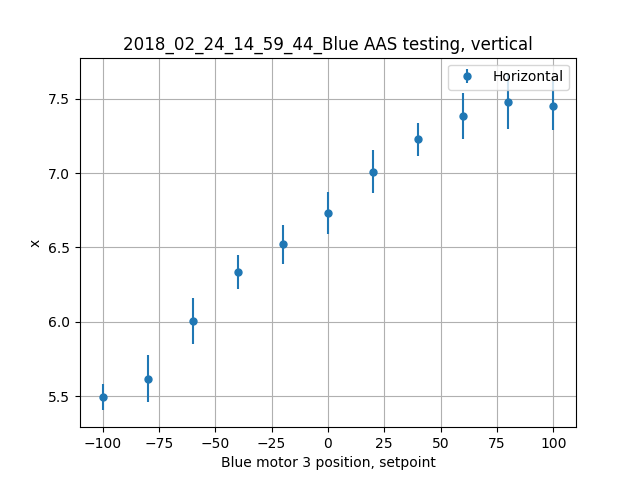

<IPython.core.display.Javascript object>


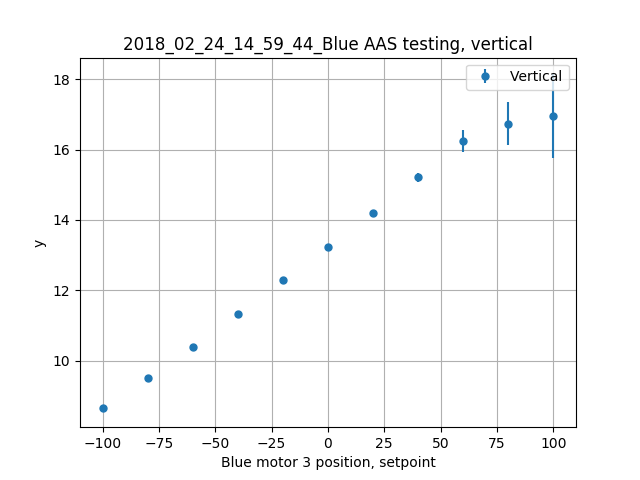

In [19]:
colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
fig, ax = plt.subplots()
xdata = []
ydata = []
yerr = []
for e in range(len(np.squeeze(retention['ivar']))):
    xdata.append(np.squeeze(retention['ivar'])[e][2])
    ydata.append(q.experiments[0]['iterations'][e]['AAS_blueside']['x'])
    yerr.append(q.experiments[0]['iterations'][e]['AAS_blueside']['sigma_x'])
ax.errorbar(xdata,ydata,yerr=yerr,fmt='o',markersize=5,label='Horizontal')

plt.show()
ax.set_title(exp_id)
#ax.set_ylim(-10, 10)
ax.set_xlabel(xlab)
ax.set_ylabel('x')
ax.grid()
ax.legend()

colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
fig, ax = plt.subplots()
xdata = []
ydata = []
yerr = []
for e in range(len(np.squeeze(retention['ivar']))):
    xdata.append(np.squeeze(retention['ivar'])[e][2])
    ydata.append(q.experiments[0]['iterations'][e]['AAS_blueside']['y'])
    yerr.append(q.experiments[0]['iterations'][e]['AAS_blueside']['sigma_y'])
ax.errorbar(xdata,ydata,yerr=yerr,fmt='o',markersize=5,label='Vertical')

plt.show()
ax.set_title(exp_id)
#ax.set_ylim(-10, 10)
ax.set_xlabel(xlab)
ax.set_ylabel('y')
ax.grid()
ax.legend()

# Horizontal

In [24]:
exp_id='2018_02_24_15_07_31_Blue AAS testing, horizontal'
data_master_path='D:/Data/' # D:\ is local SSD in the main experiment computer
exp_date="_".join(exp_id.split("_")[:3]) # Date folder name automatically generated from exp name.
exp_path=data_master_path+exp_date+'/'+exp_id+'/'
experiment_file='results.hdf5'
dp=exp_path
cuts = [[450],[450],[450]]

q = qdp.QDP(base_data_path=dp)
q.load_data_file(experiment_file)
for r in range(5):
    q.set_thresholds(cuts, roi=r)
print q.experiments[0]['variable_list']
xlab = q.experiments[0]['variable_desc'][q.experiments[0]['variable_list'][0]]['description']
q.get_thresholds()
retention = q.apply_thresholds()
#np.squeeze(retention['retention'])

[u'Blue_X']
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loadi

<IPython.core.display.Javascript object>


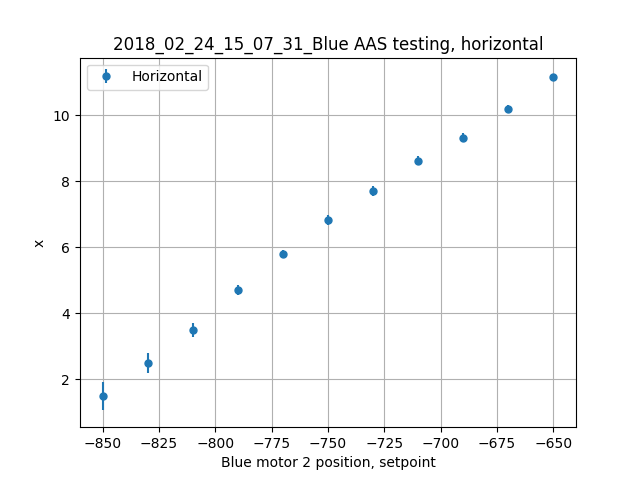

<IPython.core.display.Javascript object>


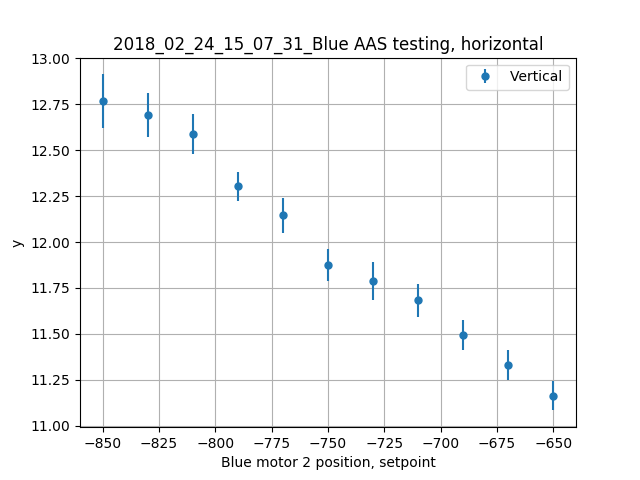

<IPython.core.display.Javascript object>


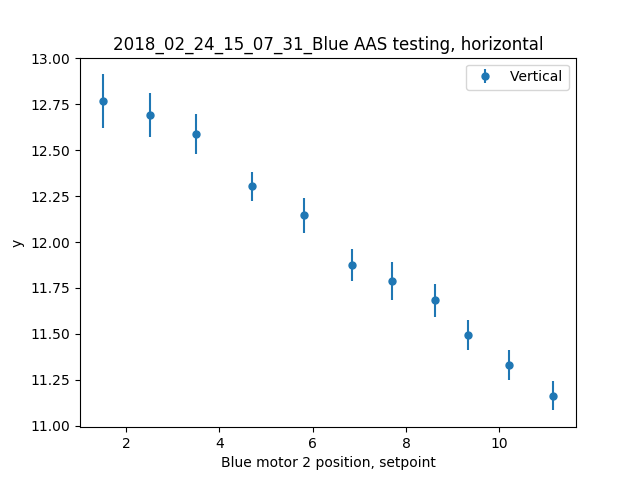

In [26]:
colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
fig, ax = plt.subplots()
xdata = []
ydata = []
yerr = []
for e in range(len(np.squeeze(retention['ivar']))):
    xdata.append(np.squeeze(retention['ivar'])[e][2])
    ydata.append(q.experiments[0]['iterations'][e]['AAS_blueside']['x'])
    yerr.append(q.experiments[0]['iterations'][e]['AAS_blueside']['sigma_x'])
ax.errorbar(xdata,ydata,yerr=yerr,fmt='o',markersize=5,label='Horizontal')

Xcoord=ydata
Xcoord_err=yerr

plt.show()
ax.set_title(exp_id)
#ax.set_ylim(-10, 10)
ax.set_xlabel(xlab)
ax.set_ylabel('x')
ax.grid()
ax.legend()

colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
fig, ax = plt.subplots()
xdata = []
ydata = []
yerr = []
for e in range(len(np.squeeze(retention['ivar']))):
    xdata.append(np.squeeze(retention['ivar'])[e][2])
    ydata.append(q.experiments[0]['iterations'][e]['AAS_blueside']['y'])
    yerr.append(q.experiments[0]['iterations'][e]['AAS_blueside']['sigma_y'])
ax.errorbar(xdata,ydata,yerr=yerr,fmt='o',markersize=5,label='Vertical')

Ycoord=ydata
Ycoord_err=yerr



<IPython.core.display.Javascript object>


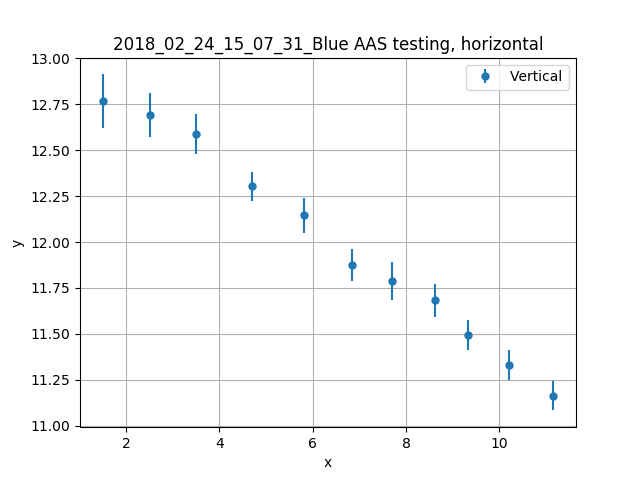

In [29]:
plt.show()
ax.set_title(exp_id)
#ax.set_ylim(-10, 10)
ax.set_xlabel(xlab)
ax.set_ylabel('y')
ax.grid()
ax.legend()

fig, ax = plt.subplots()
ax.errorbar(Xcoord,Ycoord,yerr=Ycoord_err,fmt='o',markersize=5,label='Vertical')

plt.show()
ax.set_title(exp_id)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.grid()
ax.legend()

# Open loop, blue

In [30]:
exp_id='2018_02_24_16_06_21_Blue AAS testing, open loop'
data_master_path='D:/Data/' # D:\ is local SSD in the main experiment computer
exp_date="_".join(exp_id.split("_")[:3]) # Date folder name automatically generated from exp name.
exp_path=data_master_path+exp_date+'/'+exp_id+'/'
experiment_file='results.hdf5'
dp=exp_path
cuts = [[450],[450],[450]]

q = qdp.QDP(base_data_path=dp)
q.load_data_file(experiment_file)
for r in range(5):
    q.set_thresholds(cuts, roi=r)
print q.experiments[0]['variable_list']
xlab = q.experiments[0]['variable_desc'][q.experiments[0]['variable_list'][0]]['description']
q.get_thresholds()
retention = q.apply_thresholds()
#np.squeeze(retention['retention'])

C:\Users\Rb\AppData\Local\Enthought\Canopy\User\lib\site-packages\numpy\lib\function_base.py:4011: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


[u'zz_outermost_iteration']
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading observed
no loading o

<IPython.core.display.Javascript object>


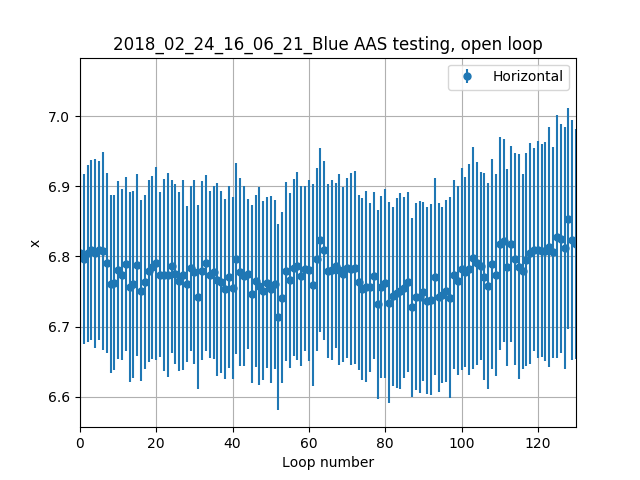

<IPython.core.display.Javascript object>


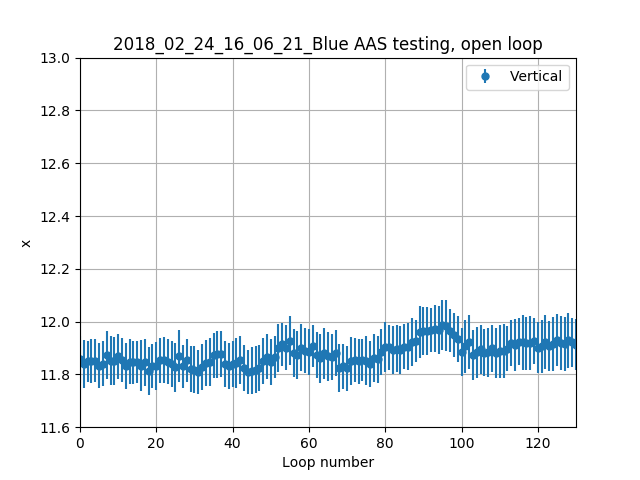

In [36]:
colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
fig, ax = plt.subplots()
xdata = []
ydata = []
yerr = []
for e in range(len(np.squeeze(retention['ivar']))):
    xdata.append(np.squeeze(retention['ivar'])[e][2])
    ydata.append(q.experiments[0]['iterations'][e]['AAS_blueside']['x'])
    yerr.append(q.experiments[0]['iterations'][e]['AAS_blueside']['sigma_x'])
ax.errorbar(xdata,ydata,yerr=yerr,fmt='o',markersize=5,label='Horizontal')

Xcoord=ydata
Xcoord_err=yerr

plt.show()
ax.set_title(exp_id)
ax.set_xlim(0,130)
#ax.set_ylim(-10, 10)
ax.set_xlabel(xlab)
ax.set_ylabel('x')
ax.grid()
ax.legend()

colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
fig, ax = plt.subplots()
xdata = []
ydata = []
yerr = []
for e in range(len(np.squeeze(retention['ivar']))):
    xdata.append(np.squeeze(retention['ivar'])[e][2])
    ydata.append(q.experiments[0]['iterations'][e]['AAS_blueside']['y'])
    yerr.append(q.experiments[0]['iterations'][e]['AAS_blueside']['sigma_y'])
ax.errorbar(xdata,ydata,yerr=yerr,fmt='o',markersize=5,label='Vertical')

Ycoord=ydata
Ycoord_err=yerr
ax.set_title(exp_id)
ax.set_xlim(0,130)
ax.set_ylim(11.6, 13)
ax.set_xlabel(xlab)
ax.set_ylabel('x')
ax.grid()
ax.legend()

<IPython.core.display.Javascript object>


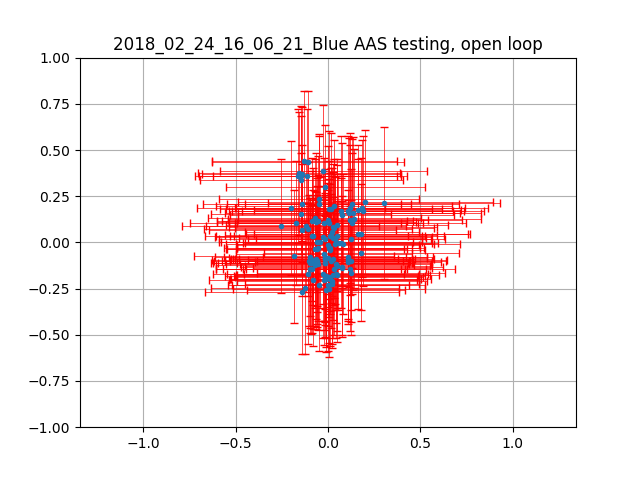

In [67]:
fig, ax = plt.subplots()
length_conversion=4.0 # um per pixel
cutoff=130
xdata=length_conversion*(Xcoord[0:cutoff]-np.nanmedian(Xcoord))
xerr=length_conversion*np.array(Xcoord_err[0:cutoff])
ydata=length_conversion*(Ycoord[0:cutoff]-np.nanmedian(Ycoord))
yerr=length_conversion*np.array(Ycoord_err[0:cutoff])
ax.errorbar(xdata,ydata,xerr=xerr,yerr=yerr,fmt='o',ecolor='red',elinewidth=0.5,markersize=3,capsize=3)

ax.set_title(exp_id)
ax.set_xlim(-1,1)
ax.set_ylim(-1, 1)
#ax.set_ylabel('x')
ax.set_aspect('equal', 'datalim')
ax.grid()
ax.legend()

In [68]:
3.75/9.26

0.40496760259179265

# Open loop, red and blue, 2018-02-27

In [9]:
exp_id='2018_02_27_11_49_16_Open loop AAS free running, N=1000'
data_master_path='D:/Data/' # D:\ is local SSD in the main experiment computer
exp_date="_".join(exp_id.split("_")[:3]) # Date folder name automatically generated from exp name.
exp_path=data_master_path+exp_date+'/'+exp_id+'/'
experiment_file='results.hdf5'
dp=exp_path
cuts = [[450],[450],[450]]

q = qdp.QDP(base_data_path=dp)
q.load_data_file(experiment_file)
for r in range(5):
    q.set_thresholds(cuts, roi=r)
print q.experiments[0]['variable_list']
xlab = q.experiments[0]['variable_desc'][q.experiments[0]['variable_list'][0]]['description']
q.get_thresholds()
retention = q.apply_thresholds()
#np.squeeze(retention['retention'])

[u'zz_outermost_iteration']


<IPython.core.display.Javascript object>


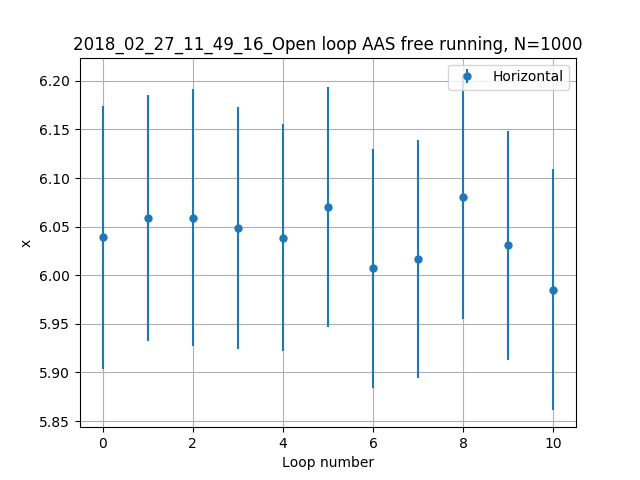

<IPython.core.display.Javascript object>


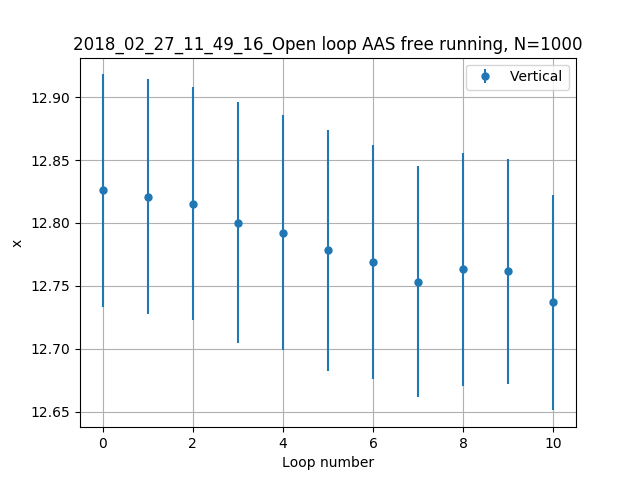

In [24]:
whichside='AAS_blueside' #'AAS_
#whichside='AAS_redside'
fig, ax = plt.subplots()
xdata = []
ydata = []
yerr = []
for e in range(len(np.squeeze(retention['ivar']))):
    xdata.append(np.squeeze(retention['ivar'])[e][2])
    ydata.append(q.experiments[0]['iterations'][e][whichside]['x'])
    yerr.append(q.experiments[0]['iterations'][e][whichside]['sigma_x'])
ax.errorbar(xdata,ydata,yerr=yerr,fmt='o',markersize=5,label='Horizontal')

Xcoord=ydata
Xcoord_err=yerr

plt.show()
ax.set_title(exp_id)
#ax.set_xlim(0,130)
#ax.set_ylim(-10, 10)
ax.set_xlabel(xlab)
ax.set_ylabel('x')
ax.grid()
ax.legend()

fig, ax = plt.subplots()
xdata = []
ydata = []
yerr = []
for e in range(len(np.squeeze(retention['ivar']))):
    xdata.append(np.squeeze(retention['ivar'])[e][2])
    ydata.append(q.experiments[0]['iterations'][e][whichside]['y'])
    yerr.append(q.experiments[0]['iterations'][e][whichside]['sigma_y'])
ax.errorbar(xdata,ydata,yerr=yerr,fmt='o',markersize=5,label='Vertical')

Ycoord=ydata
Ycoord_err=yerr
ax.set_title(exp_id)
#ax.set_xlim(0,130)
#ax.set_ylim(11.6, 13)
ax.set_xlabel(xlab)
ax.set_ylabel('x')
ax.grid()
ax.legend()

<IPython.core.display.Javascript object>


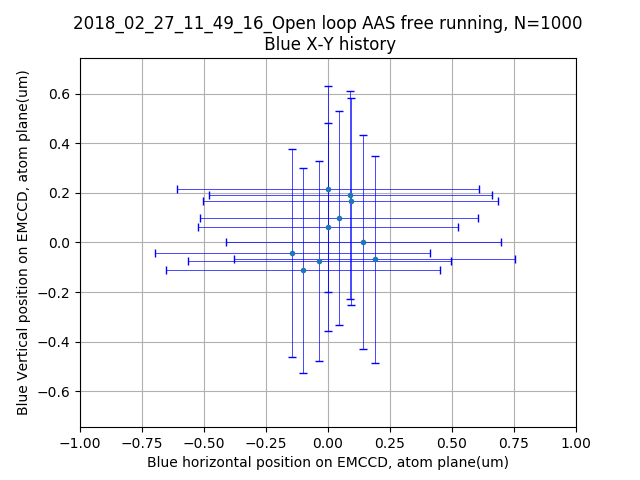

(-1, 1)

In [32]:
fig, ax = plt.subplots()
length_conversion=4.5 # um per pixel
cutoff=-1
xdata=length_conversion*(Xcoord[0:cutoff]-np.nanmedian(Xcoord))
xerr=length_conversion*np.array(Xcoord_err[0:cutoff])
ydata=length_conversion*(Ycoord[0:cutoff]-np.nanmedian(Ycoord))
yerr=length_conversion*np.array(Ycoord_err[0:cutoff])
ax.errorbar(xdata,ydata,xerr=xerr,yerr=yerr,fmt='o',ecolor='blue',elinewidth=0.5,markersize=3,capsize=3)
ax.set_title(exp_id+'\n Blue X-Y history')
ax.set_xlabel('Blue horizontal position on EMCCD, atom plane(um)')
ax.set_ylabel('Blue Vertical position on EMCCD, atom plane(um)')
ax.legend()
ax.set_aspect('equal', 'datalim')
ax.grid()
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)

<IPython.core.display.Javascript object>


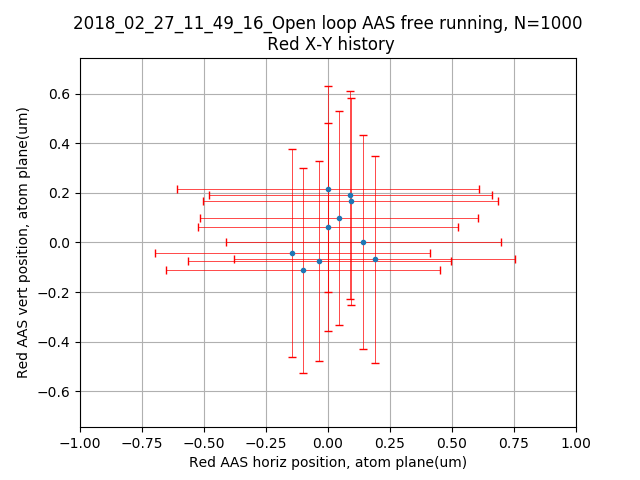

In [33]:
fig, ax = plt.subplots()
length_conversion=4.5 # um per pixel
cutoff=-1
xdata=length_conversion*(Xcoord[0:cutoff]-np.nanmedian(Xcoord))
xerr=length_conversion*np.array(Xcoord_err[0:cutoff])
ydata=length_conversion*(Ycoord[0:cutoff]-np.nanmedian(Ycoord))
yerr=length_conversion*np.array(Ycoord_err[0:cutoff])
ax.errorbar(xdata,ydata,xerr=xerr,yerr=yerr,fmt='o',ecolor='red',elinewidth=0.5,markersize=3,capsize=3)

ax.set_title(exp_id+'\n Red X-Y history')
ax.set_xlim(-1,1)
ax.set_ylim(-1, 1)
ax.set_xlabel('Red AAS horiz position, atom plane(um)')
ax.set_ylabel('Red AAS vert position, atom plane(um)')
ax.set_aspect('equal', 'datalim')
ax.grid()
ax.legend()

# Closed loop, red and blue, 2018-02-27

In [78]:
exp_id='2018_02_28_00_16_25_lowered gain, Closed loop, fixed tgap, fixed 500 measurement Ramsey'
data_master_path='D:/Data/' # D:\ is local SSD in the main experiment computer
exp_date="_".join(exp_id.split("_")[:3]) # Date folder name automatically generated from exp name.
exp_path=data_master_path+exp_date+'/'+exp_id+'/'
experiment_file='results.hdf5'
dp=exp_path
cuts = [[450],[450],[450]]

q = qdp.QDP(base_data_path=dp)
q.load_data_file(experiment_file)
for r in range(5):
    q.set_thresholds(cuts, roi=r)
print q.experiments[0]['variable_list']
xlab = q.experiments[0]['variable_desc'][q.experiments[0]['variable_list'][0]]['description']
q.get_thresholds()
retention = q.apply_thresholds()
#np.squeeze(retention['retention'])

[u'zz_outermost_iteration']
no loading observed


<IPython.core.display.Javascript object>


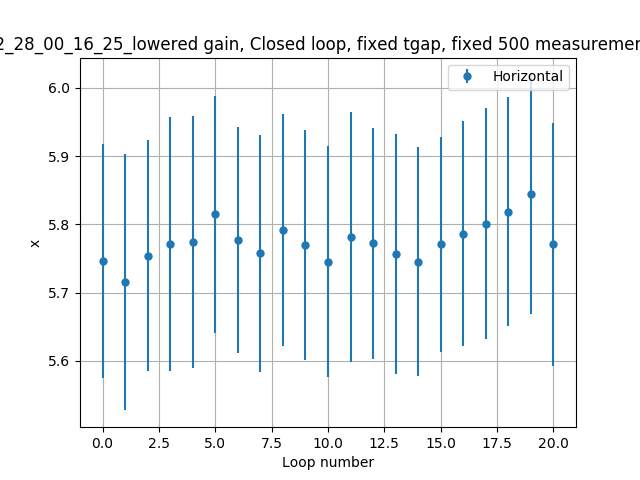

<IPython.core.display.Javascript object>


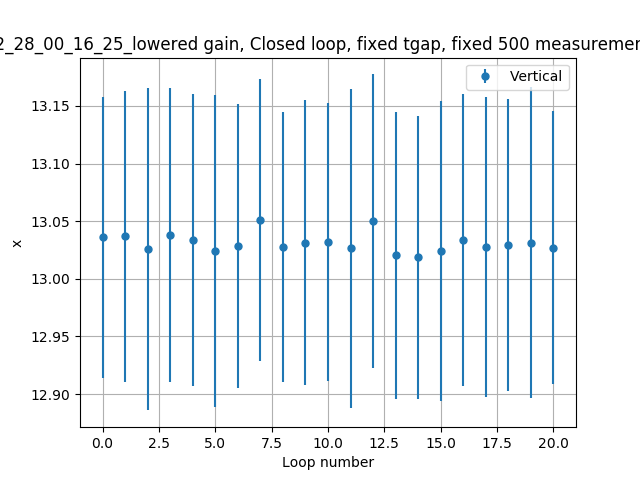

<IPython.core.display.Javascript object>


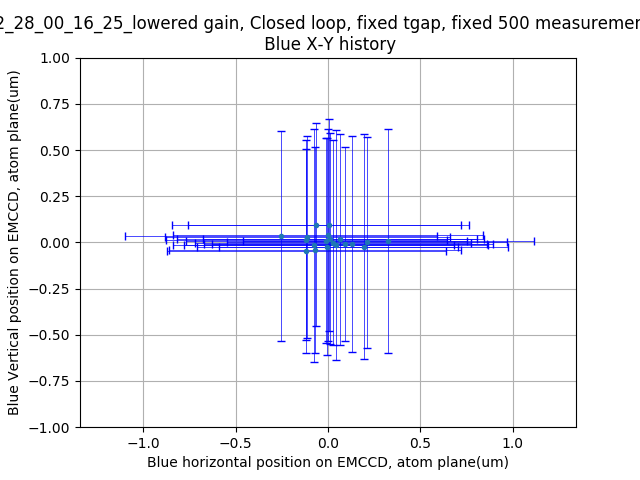

(-1, 1)

In [81]:
whichside='AAS_blueside' #'AAS_
#whichside='AAS_redside'
fig, ax = plt.subplots()
xdata = []
ydata = []
yerr = []
for e in range(len(np.squeeze(retention['ivar']))):
    xdata.append(np.squeeze(retention['ivar'])[e][2])
    ydata.append(q.experiments[0]['iterations'][e][whichside]['x'])
    yerr.append(q.experiments[0]['iterations'][e][whichside]['sigma_x'])
ax.errorbar(xdata,ydata,yerr=yerr,fmt='o',markersize=5,label='Horizontal')

Xcoord=ydata
Xcoord_err=yerr

plt.show()
ax.set_title(exp_id)
#ax.set_xlim(0,130)
#ax.set_ylim(-10, 10)
ax.set_xlabel(xlab)
ax.set_ylabel('x')
ax.grid()
ax.legend()

fig, ax = plt.subplots()
xdata = []
ydata = []
yerr = []
for e in range(len(np.squeeze(retention['ivar']))):
    xdata.append(np.squeeze(retention['ivar'])[e][2])
    ydata.append(q.experiments[0]['iterations'][e][whichside]['y'])
    yerr.append(q.experiments[0]['iterations'][e][whichside]['sigma_y'])
ax.errorbar(xdata,ydata,yerr=yerr,fmt='o',markersize=5,label='Vertical')

Ycoord=ydata
Ycoord_err=yerr
ax.set_title(exp_id)
#ax.set_xlim(0,130)
#ax.set_ylim(11.6, 13)
ax.set_xlabel(xlab)
ax.set_ylabel('x')
ax.grid()
ax.legend()
fig, ax = plt.subplots()
length_conversion=4.5 # um per pixel
cutoff=-1
xdata=length_conversion*(Xcoord[0:cutoff]-np.nanmedian(Xcoord))
xerr=length_conversion*np.array(Xcoord_err[0:cutoff])
ydata=length_conversion*(Ycoord[0:cutoff]-np.nanmedian(Ycoord))
yerr=length_conversion*np.array(Ycoord_err[0:cutoff])
ax.errorbar(xdata,ydata,xerr=xerr,yerr=yerr,fmt='o',ecolor='blue',elinewidth=0.5,markersize=3,capsize=3)
ax.set_title(exp_id+'\n Blue X-Y history')
ax.set_xlabel('Blue horizontal position on EMCCD, atom plane(um)')
ax.set_ylabel('Blue Vertical position on EMCCD, atom plane(um)')
ax.legend()
ax.set_aspect('equal', 'datalim')
ax.grid()
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)

<IPython.core.display.Javascript object>


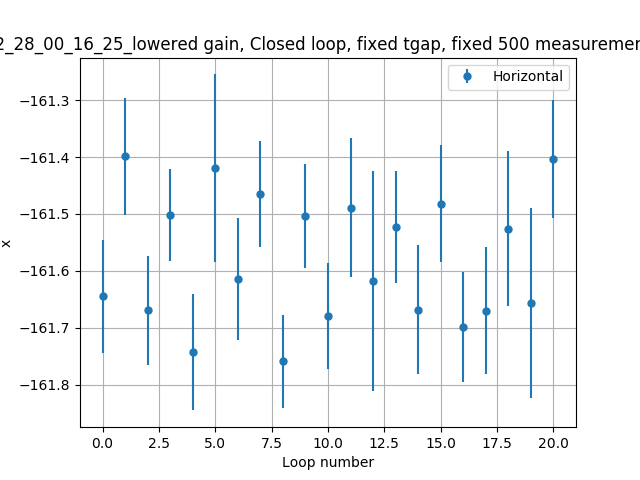

<IPython.core.display.Javascript object>


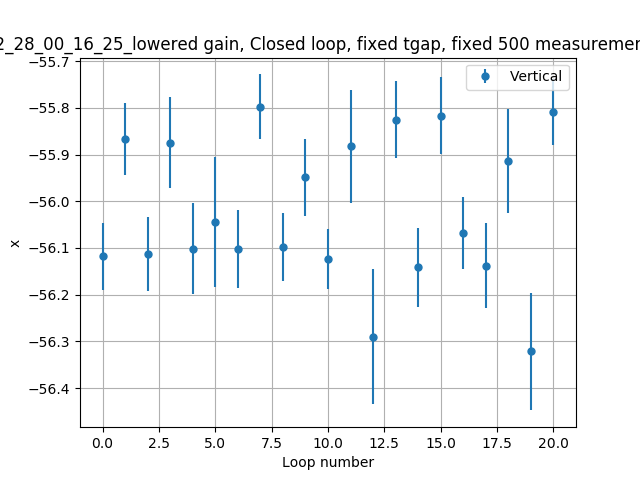

<IPython.core.display.Javascript object>


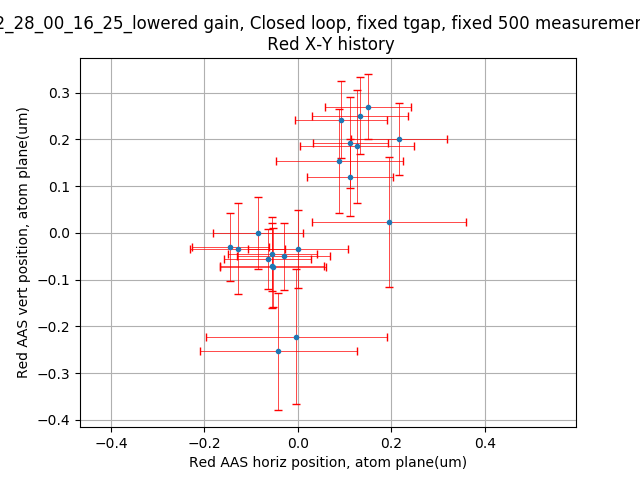

In [83]:
whichside='AAS_redside' #'AAS_
#whichside='AAS_redside'
fig, ax = plt.subplots()
xdata = []
ydata = []
yerr = []
for e in range(len(np.squeeze(retention['ivar']))):
    xdata.append(np.squeeze(retention['ivar'])[e][2])
    ydata.append(q.experiments[0]['iterations'][e][whichside]['x'])
    yerr.append(q.experiments[0]['iterations'][e][whichside]['sigma_x'])
ax.errorbar(xdata,ydata,yerr=yerr,fmt='o',markersize=5,label='Horizontal')

Xcoord=ydata
Xcoord_err=yerr

plt.show()
ax.set_title(exp_id)
#ax.set_xlim(0,130)
#ax.set_ylim(-10, 10)
ax.set_xlabel(xlab)
ax.set_ylabel('x')
ax.grid()
ax.legend()

fig, ax = plt.subplots()
xdata = []
ydata = []
yerr = []
for e in range(len(np.squeeze(retention['ivar']))):
    xdata.append(np.squeeze(retention['ivar'])[e][2])
    ydata.append(q.experiments[0]['iterations'][e][whichside]['y'])
    yerr.append(q.experiments[0]['iterations'][e][whichside]['sigma_y'])
ax.errorbar(xdata,ydata,yerr=yerr,fmt='o',markersize=5,label='Vertical')

Ycoord=ydata
Ycoord_err=yerr
ax.set_title(exp_id)
#ax.set_xlim(0,130)
#ax.set_ylim(11.6, 13)
ax.set_xlabel(xlab)
ax.set_ylabel('x')
ax.grid()
ax.legend()
fig, ax = plt.subplots()
length_conversion=1.0 # Red gives already in um units
cutoff=-1
xdata=length_conversion*(Xcoord[0:cutoff]-np.nanmedian(Xcoord))
xerr=length_conversion*np.array(Xcoord_err[0:cutoff])
ydata=length_conversion*(Ycoord[0:cutoff]-np.nanmedian(Ycoord))
yerr=length_conversion*np.array(Ycoord_err[0:cutoff])
ax.errorbar(xdata,ydata,xerr=xerr,yerr=yerr,fmt='o',ecolor='red',elinewidth=0.5,markersize=3,capsize=3)

ax.set_title(exp_id+'\n Red X-Y history')
#ax.set_xlim(-1,1)
#ax.set_ylim(-1, 1)
ax.set_xlabel('Red AAS horiz position, atom plane(um)')
ax.set_ylabel('Red AAS vert position, atom plane(um)')
ax.set_aspect('equal', 'datalim')
ax.grid()
ax.legend()

In [93]:
for e in range(len(np.squeeze(retention['ivar']))):
    print q.experiments[0]['iterations'][e]['variables']['Red_X']

-2184.85709956
-2184.56860504
-2185.29014001
-2184.91158914
-2185.18544419
-2184.5275842
-2185.16176242
-2184.99796791
-2185.59917307
-2184.86075576
-2185.18058949
-2184.78282023
-2185.14973036
-2184.98450148
-2185.36484966
-2185.00387562
-2185.39622401
-2184.923342
-2184.55666162
-2184.78222634
-2184.48060205


<IPython.core.display.Javascript object>


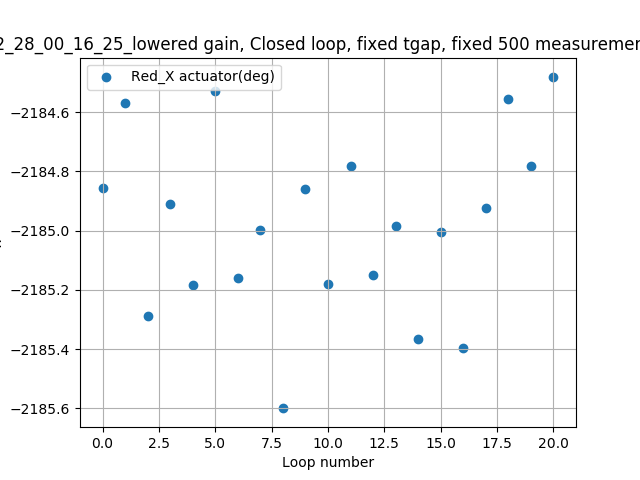

<IPython.core.display.Javascript object>


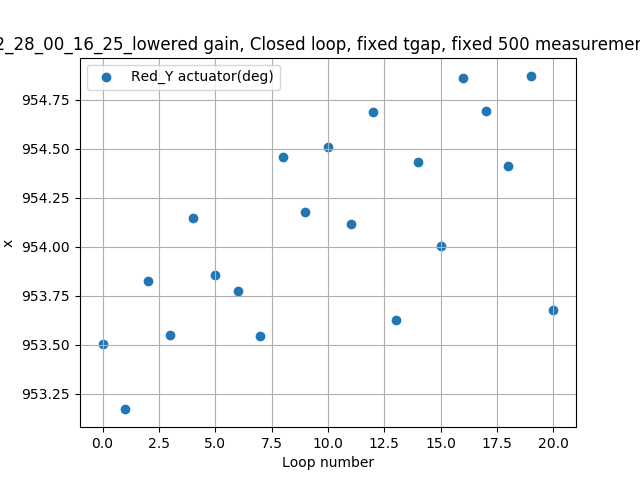

<IPython.core.display.Javascript object>


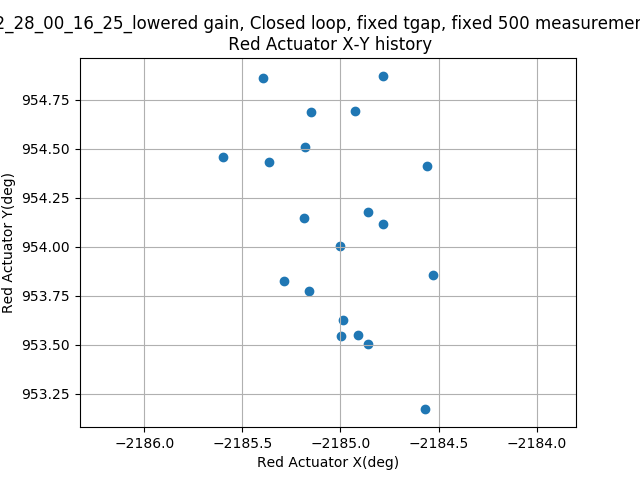

In [99]:
fig, ax = plt.subplots()
xdata = []
ydata = []
for e in range(len(np.squeeze(retention['ivar']))):
    xdata.append(np.squeeze(retention['ivar'])[e][2])
    ydata.append(q.experiments[0]['iterations'][e]['variables']['Red_X'])
ax.scatter(xdata,ydata,label='Red_X actuator(deg)')

Xcoord=ydata

plt.show()
ax.set_title(exp_id)
#ax.set_xlim(0,130)
#ax.set_ylim(-10, 10)
ax.set_xlabel(xlab)
ax.set_ylabel('x')
ax.grid()
ax.legend()

fig, ax = plt.subplots()
xdata = []
ydata = []
for e in range(len(np.squeeze(retention['ivar']))):
    xdata.append(np.squeeze(retention['ivar'])[e][2])
    ydata.append(q.experiments[0]['iterations'][e]['variables']['Red_Y'])
ax.scatter(xdata,ydata,label='Red_Y actuator(deg)')

Ycoord=ydata
ax.set_title(exp_id)
#ax.set_xlim(0,130)
#ax.set_ylim(11.6, 13)
ax.set_xlabel(xlab)
ax.set_ylabel('x')
ax.grid()
ax.legend()
fig, ax = plt.subplots()
length_conversion=1.0 # Red gives already in um units
cutoff=-1
xdata=Xcoord[0:cutoff]
ydata=Ycoord[0:cutoff]
ax.scatter(xdata,ydata)

ax.set_title(exp_id+'\n Red Actuator X-Y history')
#ax.set_xlim(-1,1)
#ax.set_ylim(-1, 1)
ax.set_xlabel('Red Actuator X(deg)')
ax.set_ylabel('Red Actuator Y(deg)')
ax.set_aspect('equal', 'datalim')
ax.grid()
ax.legend()